In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.multicomp import pairwise_tukeyhsd

data_dir = Path() / "results"
figs_dir = Path() / "figs"
figs_dir.mkdir(exist_ok=True)
condition_dir = figs_dir / "condition_diff"
condition_dir.mkdir(exist_ok=True)

In [2]:
df = pd.read_csv(data_dir / "foundation_cond_agg.csv")

# renaming columns to use same terminology
df.rename(
    columns={
        "MFQ_harm": "MFQ_Care",
        "MFQ_ingroup": "MFQ_Loyalty",
        "MFQ_authority": "MFQ_Authority",
        "MFQ_purity": "MFQ_Purity",
        "MFQ_fairness": "MFQ_Fairness",
    },
    inplace=True,
)

df.head(2)

,agent,id,condition,MFQ_Care,MFQ_Fairness,MFQ_Loyalty,MFQ_Authority,MFQ_Purity,MFV_Authority,MFV_Loyalty,MFV_Fairness,MFV_Purity,MFV_Care (p),MFV_Liberty,MFV_Care (e)
0,Claude 2.1,0,qv,3.500000,4.500000,1.666667,1.666667,1.5,1.9,1.733333,2.666667,3.571429,3.222222,2.428571,2.272727
1,Claude 2.1,2,qv,3.666667,4.833333,2.000000,2.000000,2.0,2.4,3.333333,3.000000,3.571429,3.666667,3.000000,2.272727


# Foundation endorsement on order conditions

In [3]:
# convert df to long
df_long = pd.melt(
    df,
    id_vars=["agent", "id", "condition"],
    # other cols are values
    value_vars=[x for x in df.columns if x.startswith("MFQ") or x.startswith("MFV")],
    var_name="scale",
    value_name="score",
)

# split scale into two columns: scale and foundation on "_"
df_long[["instrument", "foundation"]] = df_long["scale"].str.split("_", expand=True)

In [4]:
for agent in df_long["agent"].unique():
    print(agent)
    df_long_agent = df_long.query(f"agent == '{agent}'")
    # anova for each foundation per instrument
    formula = "score ~ C(foundation) * C(condition)"
    for instrument in df_long_agent["instrument"].unique():
        print(instrument)
        df_long_agent_scale = df_long_agent.query(f"instrument == '{instrument}'")
        anova = smf.ols(formula, data=df_long_agent_scale).fit()
        # print anova table
        tb = sm.stats.anova_lm(anova, typ=2)
        print(tb)
        print("\n")

Claude 2.1
MFQ
                                 sum_sq     df            F    PR(>F)
C(foundation)               1050.512518    4.0  2882.340373  0.000000
C(condition)                   0.953886    1.0    10.468891  0.001265
C(foundation):C(condition)     1.608327    4.0     4.412843  0.001561
Residual                      71.070698  780.0          NaN       NaN


MFV
                                sum_sq      df           F         PR(>F)
C(foundation)               194.099133     6.0  214.958429  5.351727e-181
C(condition)                 69.674137     1.0  462.970941   6.824632e-86
C(foundation):C(condition)    4.104557     6.0    4.545663   1.455496e-04
Residual                    164.338949  1092.0         NaN            NaN


GPT-4
MFQ
                                 sum_sq     df          F         PR(>F)
C(foundation)               1105.262027    4.0  951.00587  2.292465e-321
C(condition)                  43.995814    1.0  151.42211   2.832094e-32
C(foundation):C(condition)  

In [5]:
# calculate each foundation mean per condition
df_long_grouped = df_long.groupby(["agent", "condition", "foundation", "instrument"], as_index=False).agg(
    {"score": "mean"}
)
# convert to wide
df_mean_cond = df_long_grouped.pivot_table(
    index=["agent", "foundation", "instrument"], columns="condition", values="score"
)

df_mean_cond["cond_dif"] = df_mean_cond["qv"] - df_mean_cond["vq"]

df_mean_cond.sort_values("cond_dif", ascending=False)

condition                               qv        vq  cond_dif
agent      foundation instrument                              
Claude 2.1 Fairness   MFQ         4.584175  4.553672  0.030503
           Loyalty    MFQ         2.144781  2.177966 -0.033185
           Care       MFQ         3.860269  3.903955 -0.043685
GPT-4      Loyalty    MFV         3.010753  3.065169 -0.054416
Claude 2.1 Authority  MFQ         2.030303  2.096045 -0.065742
GPT-4      Care (p)   MFV         4.783751  4.851436 -0.067684
           Care       MFQ         4.645161  4.719101 -0.073940
           Fairness   MFQ         4.664875  4.762172 -0.097298
           Purity     MFV         4.440860  4.542536 -0.101676
           Fairness   MFV         4.389486  4.524345 -0.134858
           Authority  MFV         3.519355  3.665169 -0.145814
           Care (e)   MFV         3.293255  3.468846 -0.175591
Claude 2.1 Purity     MFQ         1.526936  1.774011 -0.247075
GPT-4      Liberty    MFV         3.663594  3.943820 -0.280226
Claude 2.1 Fairness   MFV         3.010101  3.393597 -0.383496
           Purity     MFV         3.673882  4.094431 -0.420549
           Care (p)   MFV         3.548822  3.979284 -0.430463
           Authority  MFV         2.466667  2.928814 -0.462147
           Care (e)   MFV         2.629017  3.180277 -0.551260
GPT-4      Authority  MFQ         2.320789  2.923221 -0.602432
Claude 2.1 Loyalty    MFV         2.731987  3.350282 -0.618296
GPT-4      Loyalty    MFQ         2.453405  3.138577 -0.685172
           Purity     MFQ         1.725806  2.466292 -0.740486
Claude 2.1 Liberty    MFV         2.626263  3.392252 -0.765989

In [6]:
df_long["llm_foundation_condition"] = df_long["agent"] + "_" + df_long["instrument"] + "_" + df_long["foundation"] + "_" + df_long["condition"]
x = pairwise_tukeyhsd(df_long["score"], (df_long["llm_foundation_condition"]))

/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Displaying adjusted comparison of each Foundation + Agent combination between conditions

In [7]:
from io import StringIO
df_tests = pd.read_html(StringIO(x.summary().as_html()))[0]
df_cond_comparison = df_tests.loc[
    df_tests["group1"].str[:-3] == df_tests["group2"].str[:-3]
]
print(df_cond_comparison["reject"].sum())
df_cond_comparison

11


,group1,group2,meandiff,p-adj,lower,upper,reject
0,Claude 2.1_MFQ_Authority_qv,Claude 2.1_MFQ_Authority_vq,0.0657,1.0000,-0.1946,0.3260,False
93,Claude 2.1_MFQ_Care_qv,Claude 2.1_MFQ_Care_vq,0.0437,1.0000,-0.2166,0.3040,False
182,Claude 2.1_MFQ_Fairness_qv,Claude 2.1_MFQ_Fairness_vq,-0.0305,1.0000,-0.2908,0.2298,False
267,Claude 2.1_MFQ_Loyalty_qv,Claude 2.1_MFQ_Loyalty_vq,0.0332,1.0000,-0.2271,0.2935,False
348,Claude 2.1_MFQ_Purity_qv,Claude 2.1_MFQ_Purity_vq,0.2471,0.0987,-0.0132,0.5074,False
425,Claude 2.1_MFV_Authority_qv,Claude 2.1_MFV_Authority_vq,0.4621,0.0000,0.2018,0.7224,True
498,Claude 2.1_MFV_Care (e)_qv,Claude 2.1_MFV_Care (e)_vq,0.5513,0.0000,0.2910,0.8116,True
567,Claude 2.1_MFV_Care (p)_qv,Claude 2.1_MFV_Care (p)_vq,0.4305,0.0000,0.1702,0.6908,True
632,Claude 2.1_MFV_Fairness_qv,Claude 2.1_MFV_Fairness_vq,0.3835,0.0000,0.1232,0.6438,True
693,Claude 2.1_MFV_Liberty_qv,Claude 2.1_MFV_Liberty_vq,0.7660,0.0000,0.5057,1.0263,True


In [8]:
df_cond_comparison.shape

(24, 7)

# Distribution by agent

In [9]:
# set axis lines to light gray
plt.rcParams["axes.edgecolor"] = "lightgray"
# tick labels to dark gray
plt.rcParams["ytick.color"] = "dimgrey"
plt.rcParams["xtick.color"] = "dimgrey"

# set grid on
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = "lightgray"

/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


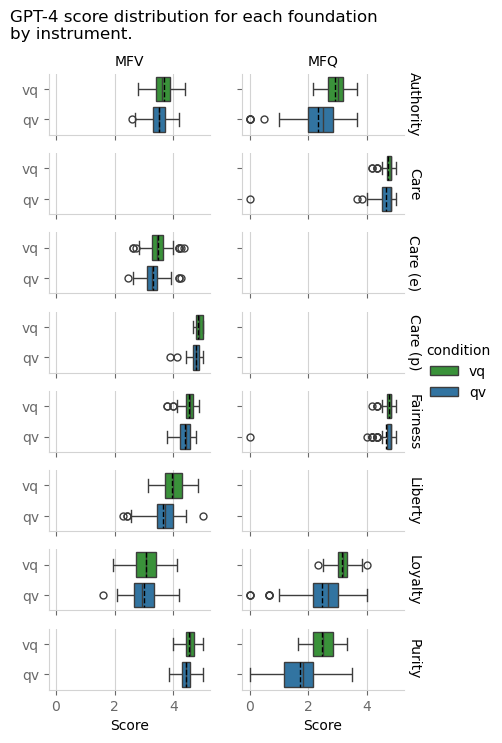

In [10]:
g = sns.catplot(
    col="instrument",
    row="foundation",
    x="score",
    y="condition",
    hue="condition",
    data=df_long.query("agent == 'GPT-4'").sort_values("foundation"),
    sharex=True,
    kind='box',
    # dodge=.4,
    height=1,
    aspect=2.2,
    margin_titles=True,
    legend=True,
    # alpha=0.95,
    palette=["#2ca02c", "#1f77b4"],
    # add dashed line with mean
    showmeans=True,
    meanline=True,
    meanprops={"linestyle": "--", "linewidth": 1, "color": "black"},
)

g.set_ylabels("")
g.set_titles(row_template="{row_name}", col_template="{col_name}",)
g.set_xlabels("Score")
# sort rows by name
plt.suptitle("GPT-4 score distribution for each foundation\nby instrument.", y=0.96, x=0.05, ha="left")
# increase space between cols
plt.subplots_adjust(wspace=0.2, hspace=0.3)
g.figure.savefig(condition_dir / "gpt_instrument.png", dpi=300, bbox_inches="tight")
g.figure.savefig(condition_dir / "gpt_instrument.pdf", dpi=300, bbox_inches="tight")

/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


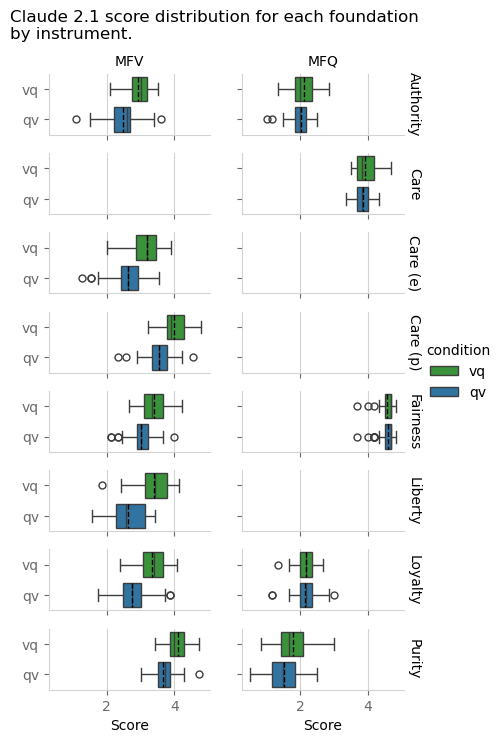

In [11]:
g = sns.catplot(
    col="instrument",
    row="foundation",
    x="score",
    y="condition",
    hue="condition",
    data=df_long.query("agent == 'Claude 2.1'").sort_values("foundation"),
    sharex=True,
    kind='box',
    # dodge=.4,
    height=1,
    aspect=2.2,
    margin_titles=True,
    legend=True,
    # alpha=0.95,
    palette=["#2ca02c", "#1f77b4"],
    # add dashed line with mean
    showmeans=True,
    meanline=True,
    meanprops={"linestyle": "--", "linewidth": 1, "color": "black"},
)

g.set_ylabels("")
g.set_titles(row_template="{row_name}", col_template="{col_name}",)
g.set_xlabels("Score")
# sort rows by name
plt.suptitle("Claude 2.1 score distribution for each foundation\nby instrument.", y=0.96, x=0.05, ha="left")
# increase space between cols
plt.subplots_adjust(wspace=0.2, hspace=0.3)
g.figure.savefig(condition_dir / "claude_instrument.png", dpi=300, bbox_inches="tight")
g.figure.savefig(condition_dir / "claude_instrument.pdf", dpi=300, bbox_inches="tight")


# MFQ Distribution

/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


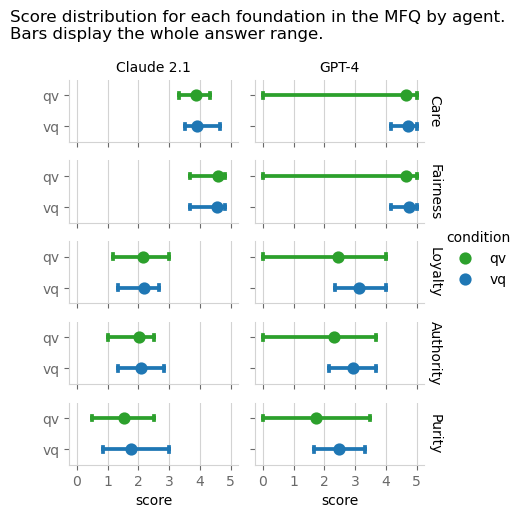

In [12]:
g = sns.catplot(
    col="agent",
    row="foundation",
    x="score",
    y="condition",
    hue="condition",
    data=df_long.query("instrument == 'MFQ'"),
    sharex=True,
    kind='point',
    estimator="mean",
    errorbar=("pi", 100),
    capsize=0.15,
    linestyles="none",
    # dodge=.4,
    height=1,
    aspect=2.2,
    margin_titles=True,
    legend=True,
    # alpha=0.95,
    palette=["#2ca02c", "#1f77b4"],
)

g.set_ylabels("")
g.set_titles(row_template="{row_name}", col_template="{col_name}",)
# set xticks from 0 to 5
g.set(xticks=range(0, 6))
plt.suptitle("Score distribution for each foundation in the MFQ by agent.\nBars display the whole answer range.", y=1.02, x=0.01, ha="left")
# increase space between cols
plt.subplots_adjust(wspace=0.1, hspace=0.3)

g.figure.savefig(condition_dir / "mfq_agent.png", dpi=300, bbox_inches="tight")
g.figure.savefig(condition_dir / "mfq_agent.pdf", dpi=300, bbox_inches="tight")


/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


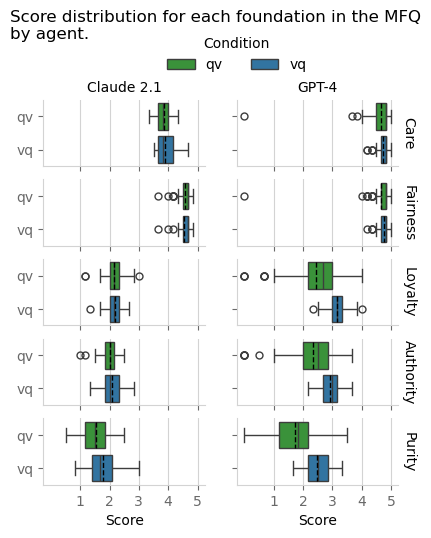

In [13]:
mfq_box = sns.catplot(
    col="agent",
    row="foundation",
    x="score",
    y="condition",
    hue="condition",
    data=df_long.query("instrument == 'MFQ'"),
    sharex=True,
    kind='box',
    # dodge=.4,
    height=1,
    aspect=2.2,
    margin_titles=True,
    legend=True,
    # alpha=0.95,
    palette=["#2ca02c", "#1f77b4"],
    # add dashed line with mean
    showmeans=True,
    meanline=True,
    meanprops={"linestyle": "--", "linewidth": 1, "color": "black"},
)

mfq_box.set(xticks=range(1,6),)
# g_mfv.set_xticklabels(step=1)
mfq_box.set_ylabels("")
mfq_box.set_xlabels("Score")
# set agent title only for first row
mfq_box.set_titles(row_template="{row_name}", col_template="{col_name}")
mfq_box._legend.remove()
mfq_box.figure.legend(ncols=2,  title="Condition", loc="upper center", bbox_to_anchor=(0.5, 1.03), frameon=False)

plt.suptitle("Score distribution for each foundation in the MFQ\nby agent.", y=1.06,  x=0.06, ha="left")
mfq_box.figure.savefig(condition_dir / "mfq_agent_box.png", dpi=300, bbox_inches="tight")
mfq_box.figure.savefig(condition_dir / "mfq_agent_box.pdf", dpi=300, bbox_inches="tight")

/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


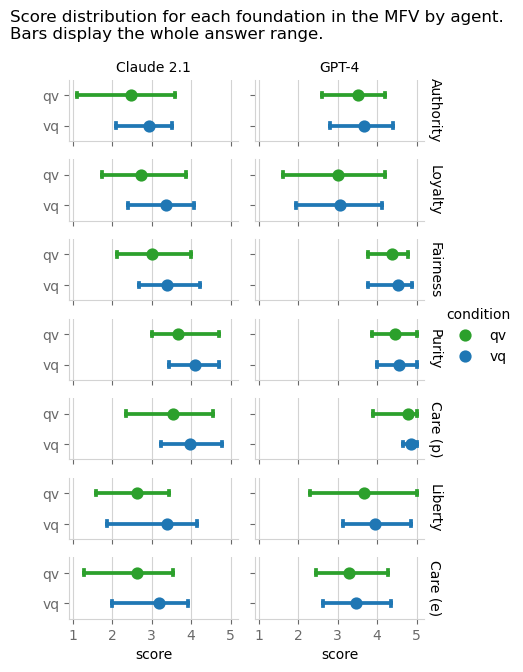

In [14]:
g_mfv = sns.catplot(
    col="agent",
    row="foundation",
    x="score",
    y="condition",
    hue="condition",
    data=df_long.query("instrument == 'MFV'"),
    sharex=True,
    kind='point',
    estimator="mean",
    errorbar=("pi", 100),
    capsize=0.15,
    linestyles="none",
    # dodge=.4,
    height=1.,
    aspect=2.2,
    margin_titles=True,
    legend=True,
    # alpha=0.95,
    palette=["#2ca02c", "#1f77b4"],
)

# set xticks from 1 to 5
g_mfv.set(xticks=range(1,6))
# g_mfv.set_xticklabels(step=1)
g_mfv.set_ylabels("")
# set agent title only for first row
g_mfv.set_titles(row_template="{row_name}", col_template="{col_name}")

plt.suptitle("Score distribution for each foundation in the MFV by agent.\nBars display the whole answer range.", y=0.98,  x=0.01, ha="left")
# increase space between cols
plt.subplots_adjust(wspace=0.1, hspace=0.3)
g_mfv.figure.savefig(condition_dir / "mfv_agent.png", dpi=300, bbox_inches="tight")
g_mfv.figure.savefig(condition_dir / "mfv_agent.pdf", dpi=300, bbox_inches="tight")

/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


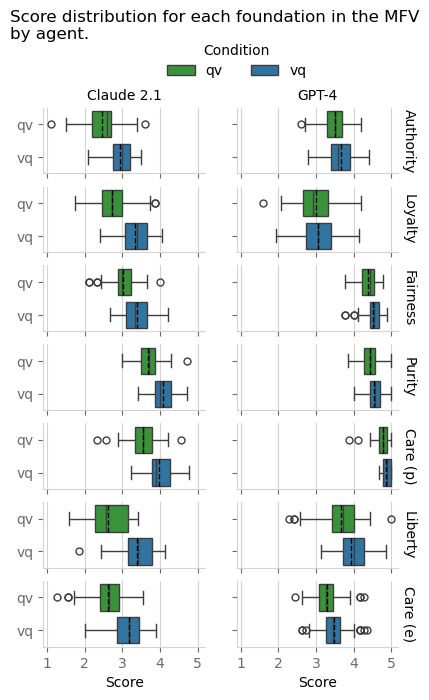

In [15]:
mfv_box = sns.catplot(
    col="agent",
    row="foundation",
    x="score",
    y="condition",
    hue="condition",
    data=df_long.query("instrument == 'MFV'"),
    sharex=True,
    kind='box',
    # dodge=.4,
    height=1,
    aspect=2.2,
    margin_titles=True,
    legend=True,
    # alpha=0.95,
    palette=["#2ca02c", "#1f77b4"],
    # add dashed line with mean
    showmeans=True,
    meanline=True,
    meanprops={"linestyle": "--", "linewidth": 1, "color": "black"},
)

mfv_box.set(xticks=range(1,6))
# g_mfv.set_xticklabels(step=1)
mfv_box.set_ylabels("")
mfv_box.set_xlabels("Score")
# set agent title only for first row
mfv_box.set_titles(row_template="{row_name}", col_template="{col_name}")

mfv_box._legend.remove()
mfv_box.figure.legend(ncols=2,  title="Condition", loc="upper center", bbox_to_anchor=(0.5, 0.99), frameon=False)

plt.suptitle("Score distribution for each foundation in the MFV\nby agent.", y=1.02,  x=0.06, ha="left")
mfv_box.figure.savefig(condition_dir / "mfv_agent_box.png", dpi=300, bbox_inches="tight")
mfv_box.figure.savefig(condition_dir / "mfv_agent_box.pdf", dpi=300, bbox_inches="tight")